In [1]:
#https://www.dummies.com/programming/python/plotting-a-sound-file-in-ipython/
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.fftpack import fft
import numpy as np
from gurobipy import *
from IPython.display import Audio
import os
import glob
import untangle

import xml.etree.ElementTree as et
import pandas as pd
import re

# Functions

In [2]:
# Function for transforming a signal with fourier
def fourier_trans(data, rate, begin_time, end_time): 
    # initialising variables
    tp_count = len(data)
    values = np.arange(int(tp_count/2))
    time_period = tp_count/rate
    frequencies = values/time_period
    
    #at what intervals time points are sampled
    sampling_interval = 1/rate;
    
    #time points
    time = np.arange(begin_time, end_time, sampling_interval);
    
    #Frequency domain representation
    fourier_transform = fft(data)/tp_count #normalized the amplitude
    fourier_transform = fourier_transform[range(int(len(data)/2))] #exclude sampling frequency   
    return frequencies, abs(fourier_transform)

# TODO: Funktion überarbeiten damit man es auch versteht!
def new_fft(data, rate):
    N = len(data)

    # sample spacing
    T = 1.0 / rate
    x = np.linspace(0.0, N*T, N)

    yf = fft(data)
    freq = np.linspace(0.0, 1.0/(2.0*T), N//2)
    ampl = 2.0/N * np.abs(yf[0:N//2])
    return freq, ampl

# Frequency domain representation
def plot_freq_domain(freq, fourier, name):
    plt.figure(figsize=(20,5))
    plt.plot(freq, fourier)
    plt.xlabel('Frequency in Hz')
    plt.ylabel('Amplitude')
    plt.xlim(0, 1400)
    plt.title(name)
    plt.show()

# TODO: Warnung herausgeben wenn bei der Teilung der Samplerate eine Fliesskommazahl entsteht
def easy_downsampling(data, rate, sampl_fac):
    ds_data = []
    for i in range(len(data)):
        if (i%sampl_fac == 0):
            ds_data.append(data[i])
    ds_rate = int(rate/sampl_fac)
    return ds_data, ds_rate

#ToDo: startwert von 0 nicht möglich überarbeiten!!
def snip_wav(data, rate, start_sec, end_sec):
    start_point = int((rate * start_sec)-1)
    end_point = int((rate * end_sec)-1)
    #print('start_point:', start_point)
    #print('end_point:', end_point)
    snip_data = data[start_point:end_point]
    #print(snip_data)  
    return snip_data, rate

def metric(target_v, approx_v):
    norm_factor = np.linalg.norm(approx_v)
    if (norm_factor != 0):
        norm_v = approx_v/norm_factor
        diff = target_v - norm_v
        diff_sum = np.sum(np.abs(diff))
        return diff_sum
    else:
        print('Der Vektor kann nicht normalisiert werden.')
        return approx_v 

## Dataframe 

In [3]:
def read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac):
    dataset = re.search(r'dataset.*\b', path).group(0)
    path_xml = path + "annotation"
    path_wav = path + "audio"  
    rows = []
    
    for xml_file in sorted(glob.glob(os.path.join(path_xml, '*.xml'))):
        tree = et.parse(xml_file)
        root = tree.getroot()
       
        for globalParam in root.findall('globalParameter'):
            audio_file = globalParam.find('audioFileName').text
            
            # Read wav-file
            wav_file = path_wav + '/' + audio_file
            rate, data = wav.read(wav_file)

        for transcription in root.findall('transcription'):

            for event in transcription.findall('event'):
                res = []
                res.append(dataset)
                res.append(audio_file)

                for elem in df_cols[len(res):]:
                    if event is not None:
                        if event.find(elem) is not None:
                            res.append(event.find(elem).text)
                            
                            if elem == 'onsetSec':
                                onsetSec = event.find(elem).text
                                start_sec = round(offset_sec + float(onsetSec), 3)
                                end_sec = round(start_sec + duration_sec, 3)

                                # Snip and downsampling audio-file
                                data_snip, rate_snip = snip_wav(data, rate, start_sec, end_sec)
                                data_down, rate_down = easy_downsampling(data_snip, rate_snip, sampl_fac)
                                
                                # Calc FFT
                                freq, fourier = new_fft(data_down, rate_down)
                                                       
                        elif elem == 'FFT':
                            res.append(fourier)

                        elif elem == 'Freq':
                            res.append(freq)
                        else:
                            res.append(None)
                    else:
                        res.append(None)

                rows.append({df_cols[i]: res[i] for i, _ in enumerate(df_cols)})

    return pd.DataFrame(rows, columns=df_cols)

# Init Dataframe

In [4]:
# Set audio snippets and sample compression
offset_sec = 0.01
duration_sec = 0.03
sampl_fac = 4

# Create empty Dataframe
df_cols = ['dataset', 'audioFileName', 'pitch', 'onsetSec', 'FFT', 'Freq']
df_ref = pd.DataFrame(columns=df_cols)
df_test = pd.DataFrame(columns=df_cols)

# Create Dataframe with reference tones

In [5]:
%%time
# paths
path_main = "IDMT-SMT-GUITAR_V2/"
path_main_ref = path_main + "dataset1/Fender Strat Clean Neck SC/"

df_ref = read_xml_to_df(path_main_ref, df_cols, offset_sec, duration_sec, sampl_fac)
df_ref

Wall time: 291 ms


,dataset,audioFileName,pitch,onsetSec,FFT,Freq
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,40,0.2,"[112.91238670694864, 142.95352892246297, 738.0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,41,0.2,"[26.48942598187311, 171.64182200771023, 590.61...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,42,0.2,"[314.88821752265864, 373.76003229876795, 552.5...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,43,0.2,"[45.86102719033233, 46.42528243979775, 92.7225...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,44,0.2,"[240.53776435045316, 312.75920711458843, 379.8...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
...,...,...,...,...,...,...
73,dataset1/Fender Strat Clean Neck SC,G53-72608-1111-00074.wav,72,0.2,"[72.13293051359517, 99.2535140656278, 77.70446...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
74,dataset1/Fender Strat Clean Neck SC,G53-73609-1111-00075.wav,73,0.2,"[25.794561933534744, 20.178017283577663, 20.02...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
75,dataset1/Fender Strat Clean Neck SC,G53-74610-1111-00076.wav,74,0.2,"[85.50453172205438, 96.43342816629888, 70.7376...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
76,dataset1/Fender Strat Clean Neck SC,G53-75611-1111-00077.wav,75,0.2,"[113.25075528700906, 75.41230597844311, 67.945...","[0.0, 33.61280487804878, 67.22560975609755, 10..."


# Create Dataframe with testdatas

In [6]:
%%time
# paths testdata
# ToDO: Automatisieren #os.listdir(path_main + path_dataset)

path_testdata = [
    path_main + 'dataset1/Fender Strat Clean Neck SC/',
    path_main + 'dataset1/Fender Strat Clean Neck SC Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge HU Chords/',
    path_main + 'dataset1/Ibanez Power Strat Clean Bridge+Neck SC/',
    path_main + 'dataset1/Ibanez Power Strat Clean Neck HU/',
    path_main + 'dataset2/']

for path in path_testdata[:6]:
    df_act = read_xml_to_df(path, df_cols, offset_sec, duration_sec, sampl_fac)
    df_test = df_test.append(df_act, ignore_index=True)
df_test

Wall time: 1.71 s


,dataset,audioFileName,pitch,onsetSec,FFT,Freq
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,40,0.2,"[112.91238670694864, 142.95352892246297, 738.0...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,41,0.2,"[26.48942598187311, 171.64182200771023, 590.61...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,42,0.2,"[314.88821752265864, 373.76003229876795, 552.5...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,43,0.2,"[45.86102719033233, 46.42528243979775, 92.7225...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,44,0.2,"[240.53776435045316, 312.75920711458843, 379.8...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
...,...,...,...,...,...,...
791,dataset1/Ibanez Power Strat Clean Neck HU,G53-72608-1111-00152.wav,72,0.2,"[76.12084592145015, 134.41369928125704, 81.052...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
792,dataset1/Ibanez Power Strat Clean Neck HU,G53-73609-1111-00153.wav,73,0.203,"[91.22658610271904, 138.75531342119078, 45.890...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
793,dataset1/Ibanez Power Strat Clean Neck HU,G53-74610-1111-00154.wav,74,0.212,"[66.94864048338368, 99.54505952809473, 88.7187...","[0.0, 33.61280487804878, 67.22560975609755, 10..."
794,dataset1/Ibanez Power Strat Clean Neck HU,G53-75611-1111-00155.wav,75,0.202,"[142.24773413897282, 203.67688214944704, 175.9...","[0.0, 33.61280487804878, 67.22560975609755, 10..."


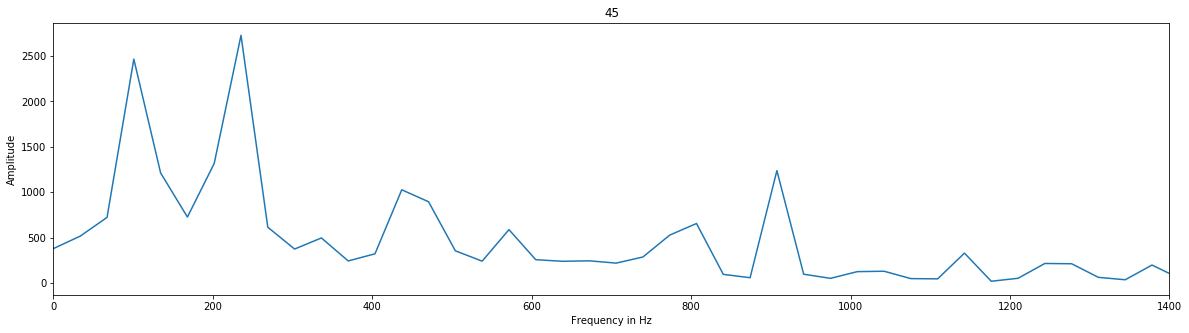

In [7]:
plot_freq_domain(df_ref.Freq[5], df_ref.FFT[5], df_ref.pitch[5])

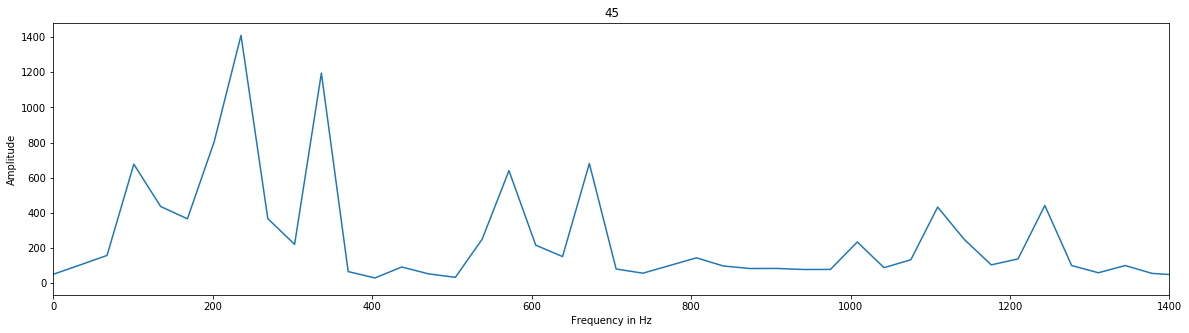

In [8]:
plot_freq_domain(df_ref.Freq[6], df_ref.FFT[6], df_ref.pitch[6])

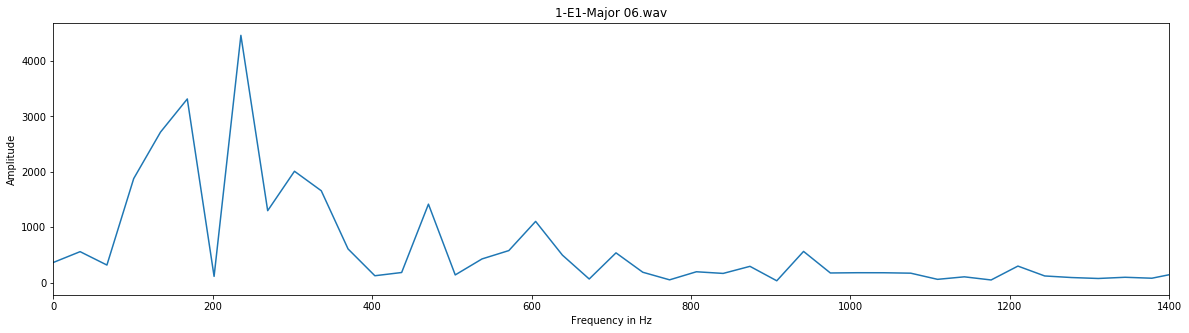

In [9]:
plot_freq_domain(df_test.Freq[115], df_test.FFT[115], df_test.audioFileName[115])

# Gurobi

In [10]:
# Build Model
m = Model('AMt')

lambs = []
for lamb in range(len(df_ref)):
    lambs.append(m.addVar(lb = 0, vtype = GRB.CONTINUOUS, name = 'lamb_' + str(lamb)))
m.update()

Academic license - for non-commercial use only


In [11]:
'''
%%time
#Optimize Signal

deviation = 0
approxi_sgn = 0
 
for sgn in range(len(mischsignal)):
#for sgn in range(100):
    for lamb in range(len(lambs)):
        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]
        
    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))
    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'
    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden
    # Überprüfen ob der Betrag der Differenz besser geeignet ist?
print('Deviation is calculated.')
'''

"\n%%time\n#Optimize Signal\n\ndeviation = 0\napproxi_sgn = 0\n \nfor sgn in range(len(mischsignal)):\n#for sgn in range(100):\n    for lamb in range(len(lambs)):\n        approxi_sgn += lambs[lamb] * ref_note[lamb]['fourier'][sgn]\n        \n    deviation += ((mischsignal[sgn] - approxi_sgn)*(mischsignal[sgn] - approxi_sgn))\n    # deviation wird ausmultipliziert stattdessen die für 'mischsignal[sgn] - approxi_sgn'\n    # eine Gurobi-Variable (m.addVar  inkl. constr.) verwenden\n    # Überprüfen ob der Betrag der Differenz besser geeignet ist?\nprint('Deviation is calculated.')\n"

In [12]:
%%time
vec_pred = []

for index, row in df_test.iterrows():
    mischsignal = row.FFT
    #print(row.audioFileName)


    # Schlaufen vertauscht
    cost_function = 0
    approxi_sgn = 0

    for lamb in range(len(lambs)):
        la = lambs[lamb]
        #print('la:', la)
        #note = ref_note[lamb]['fourier']
        note = df_ref.FFT[lamb]

        for sgn in range(len(mischsignal)):
            approxi_sgn = la * note[sgn]
            mi = mischsignal[sgn]
            cost_function += ((mi - approxi_sgn)*(mi - approxi_sgn))
    #print('Cost Function is created')

    m.params.outputflag = 0 # Infotext ausblenden
    m.setObjective(cost_function, GRB.MINIMIZE)
    m.optimize()



    approx_v = []

    for v in m.getVars():
        #print('%s: %g' % (v.varName, v.x))
        approx_v.append(v.x)

    vec_pred.append(approx_v)

Wall time: 13min 2s


In [13]:
df_test['Vec_Pred'] = vec_pred
df_test

,dataset,audioFileName,pitch,onsetSec,FFT,Freq,Vec_Pred
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,40,0.2,"[112.91238670694864, 142.95352892246297, 738.0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[1.000000000000001, 0.8516496107785423, 0.8769..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,41,0.2,"[26.48942598187311, 171.64182200771023, 590.61...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.8387454681762534, 1.0000000000000013, 0.929..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,42,0.2,"[314.88821752265864, 373.76003229876795, 552.5...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.5939341502205836, 0.6389020779021982, 1.000..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,43,0.2,"[45.86102719033233, 46.42528243979775, 92.7225...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.4840196112534764, 0.6976988536352277, 0.998..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,44,0.2,"[240.53776435045316, 312.75920711458843, 379.8...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.6531159684649682, 0.7779234627660159, 1.059..."
...,...,...,...,...,...,...,...
791,dataset1/Ibanez Power Strat Clean Neck HU,G53-72608-1111-00152.wav,72,0.2,"[76.12084592145015, 134.41369928125704, 81.052...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.25036262882265325, 0.33754832061928525, 0.3..."
792,dataset1/Ibanez Power Strat Clean Neck HU,G53-73609-1111-00153.wav,73,0.203,"[91.22658610271904, 138.75531342119078, 45.890...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.26907542597284023, 0.308658835688164, 0.452..."
793,dataset1/Ibanez Power Strat Clean Neck HU,G53-74610-1111-00154.wav,74,0.212,"[66.94864048338368, 99.54505952809473, 88.7187...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.23237242393578197, 0.2682601654349696, 0.34..."
794,dataset1/Ibanez Power Strat Clean Neck HU,G53-75611-1111-00155.wav,75,0.202,"[142.24773413897282, 203.67688214944704, 175.9...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.28018137102470086, 0.2937786269220882, 0.38..."


In [14]:
# Berechnung Vector target
def calc_target_vec(pitch):
    pitch_start = 40
    #pitch_end = 76
    pitch_end = pitch_start + 77
    target_vec = []
    
    if pitch_start <= pitch <= pitch_end:
        for pitch_act in range(pitch_start, pitch_end+1):
            
            if pitch_act == pitch:
                target_vec.append(1)
            else:
                target_vec.append(0)
    else:
        print('Pitch muss innerhalb der Range({} - {})!'.format(pitch_start, pitch_end))
    
    return target_vec

# Metrik berechnen

In [15]:
# Calc all target vectors
target_pitches = df_test.pitch.array
target_vec = []

for pitch in target_pitches:
    target_vec.append(calc_target_vec(int(pitch)))

df_test['Vec_Target'] = target_vec
df_test.head()

,dataset,audioFileName,pitch,onsetSec,FFT,Freq,Vec_Pred,Vec_Target
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,40,0.2,"[112.91238670694864, 142.95352892246297, 738.0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[1.000000000000001, 0.8516496107785423, 0.8769...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,41,0.2,"[26.48942598187311, 171.64182200771023, 590.61...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.8387454681762534, 1.0000000000000013, 0.929...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,42,0.2,"[314.88821752265864, 373.76003229876795, 552.5...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.5939341502205836, 0.6389020779021982, 1.000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,43,0.2,"[45.86102719033233, 46.42528243979775, 92.7225...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.4840196112534764, 0.6976988536352277, 0.998...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,44,0.2,"[240.53776435045316, 312.75920711458843, 379.8...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.6531159684649682, 0.7779234627660159, 1.059...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
# Calc Pitch score for all events
pitch_score = []
vec_target = df_test.pitch.array

for vec in range(len(vec_pred)):
    pitch_score.append(metric(target_vec[vec], vec_pred[vec]))
    
df_test['Pitch_Score'] = pitch_score

In [17]:
df_test.head()

,dataset,audioFileName,pitch,onsetSec,FFT,Freq,Vec_Pred,Vec_Target,Pitch_Score
0,dataset1/Fender Strat Clean Neck SC,G53-40100-1111-00001.wav,40,0.2,"[112.91238670694864, 142.95352892246297, 738.0...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[1.000000000000001, 0.8516496107785423, 0.8769...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.647875
1,dataset1/Fender Strat Clean Neck SC,G53-41101-1111-00002.wav,41,0.2,"[26.48942598187311, 171.64182200771023, 590.61...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.8387454681762534, 1.0000000000000013, 0.929...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.700176
2,dataset1/Fender Strat Clean Neck SC,G53-42102-1111-00003.wav,42,0.2,"[314.88821752265864, 373.76003229876795, 552.5...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.5939341502205836, 0.6389020779021982, 1.000...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.641205
3,dataset1/Fender Strat Clean Neck SC,G53-43103-1111-00004.wav,43,0.2,"[45.86102719033233, 46.42528243979775, 92.7225...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.4840196112534764, 0.6976988536352277, 0.998...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.255340
4,dataset1/Fender Strat Clean Neck SC,G53-44104-1111-00005.wav,44,0.2,"[240.53776435045316, 312.75920711458843, 379.8...","[0.0, 33.61280487804878, 67.22560975609755, 10...","[0.6531159684649682, 0.7779234627660159, 1.059...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8.580911
